In [691]:
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy import interp
from itertools import cycle
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, f1_score

warnings.filterwarnings('ignore')

In [692]:
df_train = pd.read_csv('../Dataset/kendaraan_train_clean.csv')
df_train.head()

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,0.0,0.153846,1.0,0.634615,1.0,0.0,0.0,0.047251,0.932099,0.301038,0
1,1.0,0.430769,1.0,0.750000,0.0,2.0,1.0,0.043104,0.172840,0.512111,0
2,1.0,0.015385,1.0,0.884615,1.0,0.0,0.0,0.056002,0.981481,0.377163,0
3,0.0,0.584615,1.0,0.923077,0.0,1.0,0.0,0.000000,0.759259,0.183391,0
4,1.0,0.461538,1.0,0.673077,0.0,2.0,1.0,0.059953,0.537037,0.636678,0


In [693]:
def transform_data(df):
	X = df.drop('Tertarik', axis=1)
	y = df['Tertarik']

	return X, y
 

def define_model():
	metrics = [
		keras.metrics.BinaryAccuracy(name='accuracy'),
		keras.metrics.Precision(name='precision'),
		keras.metrics.Recall(name='recall'),
		keras.metrics.AUC(name='auc'),
		keras.metrics.AUC(name='prc', curve='PR'),
	]

	model = Sequential()
	model.add(Dense(64, activation="relu"))
	model.add(Dense(32, activation="relu"))
	model.add(Dropout(0.5)),
	model.add(Dense(1, activation='sigmoid'))

	model.compile(
		optimizer=keras.optimizers.Adam(learning_rate=1e-3),
		loss=BinaryCrossentropy(),
		metrics=metrics
	)

	return model


def calculate_class_weight(df):
	total = len(df)

	neg = len(df[df['Tertarik'] == 0])
	pos = len(df[df['Tertarik'] == 1])

	weight_for_0 = (1 / neg) * (total / 2.0)
	weight_for_1 = (1 / pos) * (total / 2.0)
	weights = {0: weight_for_0, 1: weight_for_1}

	return weights


EarlyStop = EarlyStopping(
    monitor='val_recall',
    patience=6,
    mode='max',
    restore_best_weights=True,
	verbose=0
)

trainX, testX = transform_data(df_train)


### **Melatih Model Deep Learning** 

In [694]:
model = define_model()

history = model.fit(
    trainX, testX,
    epochs=100,
    class_weight=calculate_class_weight(df_train),
    verbose=1,
    callbacks=EarlyStop,
    batch_size=128,
    validation_split=0.2
)


Epoch 1/100
1786/1786 [==============================] - 6s 3ms/step - loss: 0.4571 - accuracy: 0.6558 - precision: 0.2550 - recall: 0.9432 - auc: 0.8218 - prc: 0.2961 - val_loss: 0.4664 - val_accuracy: 0.6765 - val_precision: 0.2670 - val_recall: 0.9343 - val_auc: 0.8356 - val_prc: 0.3191
Epoch 2/100
1786/1786 [==============================] - 4s 2ms/step - loss: 0.4446 - accuracy: 0.6702 - precision: 0.2634 - recall: 0.9428 - auc: 0.8338 - prc: 0.3125 - val_loss: 0.4878 - val_accuracy: 0.6713 - val_precision: 0.2657 - val_recall: 0.9485 - val_auc: 0.8400 - val_prc: 0.3258 - precision: 0.2620 - recall: 0.9434 - auc: 0.8331 - prc:  - ETA: 0s - loss: 0.4442 - accuracy: 0.6697 - precision: 0.2624 - recall: 0.9422 - auc: 0.833
Epoch 3/100
1786/1786 [==============================] - 4s 2ms/step - loss: 0.4418 - accuracy: 0.6778 - precision: 0.2673 - recall: 0.9375 - auc: 0.8372 - prc: 0.3191 - val_loss: 0.4713 - val_accuracy: 0.6808 - val_precision: 0.2697 - val_recall: 0.9341 - val_auc:

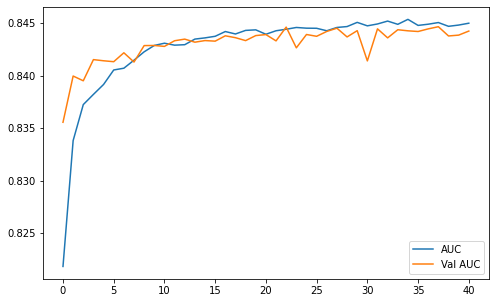

In [724]:
plt.figure(figsize=(8, 5))
plt.plot('auc', data=history.history, label='AUC')
plt.plot('val_auc', data=history.history, label='Val AUC')
plt.legend(loc='lower right')
plt.show()

### **Evaluasi Model**

In [703]:
def plot_cm(labels, predictions_pure, p=0.5):

    predictions = model.predict(predictions_pure)
    cm = confusion_matrix(labels, predictions > p)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    sns.heatmap(cm, annot=True, xticklabels=[0, 1], yticklabels=[0, 1], cmap='flare', fmt='d', ax=axes[0])
    axes[0].set_title('Confusion Matrix DL, P>0.5')

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    lw = 2
    n_classes = 2
    axes[0].set_title(f'Confusion Matrix DL, P={p}')
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels, predictions)
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(labels, predictions > p)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="best")
    plt.show()

    return predictions


### **Prediksi Dan Evaluasi Data Test**

In [704]:
df = pd.read_csv('../Dataset/kendaraan_test_clean.csv')
df.head()

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,0,0.446154,1,0.153846,0,1,1,0.082475,0.154321,0.467128,0
1,1,0.030769,1,0.903846,1,0,0,0.068822,0.932099,0.799308,0
2,1,0.061538,1,0.538462,1,0,0,0.200636,0.932099,0.179931,0
3,1,0.400000,1,0.153846,1,1,0,0.062575,0.759259,0.083045,0
4,1,0.230769,1,0.442308,0,1,1,0.045268,0.932099,0.757785,0


In [705]:
trainy = df.drop('Tertarik', axis=1)
testy = df['Tertarik']

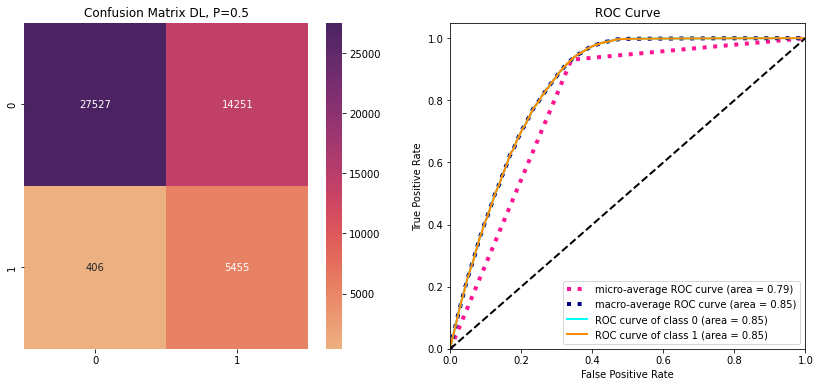

loss :  0.4605094790458679
accuracy :  0.6923319101333618
precision :  0.27681922912597656
recall :  0.930728554725647
auc :  0.850374698638916
prc :  0.3557424247264862
f1-score : 0.427


In [706]:
predictions = plot_cm(testy, trainy)
baseline_test_results = model.evaluate(trainy, testy, verbose=0)
for name, value in zip(model.metrics_names, baseline_test_results):
  print(name, ': ', value)

print('f1-score :', round(f1_score(testy, predictions > 0.5), 3))
